# DS-7331 Machine Learning Mini Project
## Airbnb Price Data - Logistic and SVM
### Allen Miller, Ana Glaser, Jake Harrison, Lola Awodipe

https://nbviewer.jupyter.org/github/allenmiller17/SMU_7331_ML1_Project_1/blob/main/Project_1_Final_Write_Up.ipynb

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [2]:
#importing the data
pdata = pd.read_csv("airbnb.csv")

### Business Understanding

For our project, we decided to use AirBnb data from six major cities in the United States from kaggle.com. Our objectives are to predict how much an airbnb would cost per night and to classifiy the type of property. We will determine the effectiveness of our price projection by assessing the MAPE (Mean Absolute Percent Error) and 10-fold cross-validation.  To assess the effectiveness of our classification, we will look at the confusion matrix results and adjust the probability threshold as needed to ensure we maximize the classification accuracy.

In [3]:
#observing a sample of the data
pdata.head()

,id,log_price,property_type,room_type,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,...,instant_bookable,last_review,latitude,longitude,neighbourhood,number_of_reviews,review_scores_rating,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,3,1.0,Real Bed,strict,True,NYC,...,f,7/18/2016,40.696524,-73.991617,Brooklyn Heights,2,100.0,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,7,1.0,Real Bed,strict,True,NYC,...,t,9/23/2017,40.766115,-73.989040,Hell's Kitchen,6,93.0,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,5,1.0,Real Bed,moderate,True,NYC,...,t,9/14/2017,40.808110,-73.943756,Harlem,10,92.0,10027,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,4,1.0,Real Bed,flexible,True,SF,...,f,NaN,37.772004,-122.431619,Lower Haight,0,NaN,94117,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,2,1.0,Real Bed,moderate,True,DC,...,t,1/22/2017,38.925627,-77.034596,Columbia Heights,4,40.0,20009,0.0,1.0


#### Data Meaning Type

There are numerous types of data in the set. The int64 represents integer values, float64 are double variables that contain decimals. The object types are categorical features, bool means its a binary variable, implying the existance or lack of a feature. The log_price is necessary because of the considerable skewness of the price variable.  There are several ordinal variables: accommodates, bathrooms, bedroom and beds.  Zip codes are nominal.

In [4]:
#observing data characteristics
pdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      74111 non-null  int64  
 1   log_price               74111 non-null  float64
 2   property_type           74111 non-null  object 
 3   room_type               74111 non-null  object 
 4   accommodates            74111 non-null  int64  
 5   bathrooms               73911 non-null  float64
 6   bed_type                74111 non-null  object 
 7   cancellation_policy     74111 non-null  object 
 8   cleaning_fee            74111 non-null  bool   
 9   city                    74111 non-null  object 
 10  description             74111 non-null  object 
 11  first_review            58247 non-null  object 
 12  host_has_profile_pic    73923 non-null  object 
 13  host_identity_verified  73923 non-null  object 
 14  host_response_rate      55812 non-null

## Data Quality

#### Missing values

The dataset contained 26 variables with missing data for 12 variables:
first_review, host_has_profile_pic, host_identity_verified, host_response_rate, host_since, last_review,
neighborhood, review_scores_rating, zipped, bathrooms, bedrooms and beds all had missing data.


The missing values came in two forms:
In the form of null values (NAs)
In the form string missing values such as “ ” or “N/A”. To avoid modeling with incomplete data and in order not to end up with incorrect results, we started working on imputing the values of the missing data.

The most prominent missing value was review_scores_rating variables. For this variable, the missing values were an empty string. We tackled the missing values using the imputation strategy of the median values. We proceed with the EDA on the review_scores_rating and the info output shows the non-null record count before and the values were imputed with the median value. Categorical variables with missing values were removed.

#### Duplicate values

We checked the data for duplicate values and we did not find any.

In [5]:
#checking for duplicate records
dupCount = pdata.duplicated()
sum(dupCount)

0

In [6]:
#imputing missing numerical data, removing records with missing categorical values
pdata = pdata.fillna(pdata.median())
pdata = pdata.dropna()

In [7]:
#observing impact of data clean-up
pdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43320 entries, 1 to 74110
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      43320 non-null  int64  
 1   log_price               43320 non-null  float64
 2   property_type           43320 non-null  object 
 3   room_type               43320 non-null  object 
 4   accommodates            43320 non-null  int64  
 5   bathrooms               43320 non-null  float64
 6   bed_type                43320 non-null  object 
 7   cancellation_policy     43320 non-null  object 
 8   cleaning_fee            43320 non-null  bool   
 9   city                    43320 non-null  object 
 10  description             43320 non-null  object 
 11  first_review            43320 non-null  object 
 12  host_has_profile_pic    43320 non-null  object 
 13  host_identity_verified  43320 non-null  object 
 14  host_response_rate      43320 non-null

In [8]:
#unlogging the logged price data field for easier interpretation
pdata['price'] = np.exp(pdata.log_price)

In [9]:
#evaluating unique values
pdata.nunique()

id                        43320
log_price                   647
property_type                31
room_type                     3
accommodates                 16
bathrooms                    17
bed_type                      5
cancellation_policy           5
cleaning_fee                  2
city                          6
description               42958
first_review               2519
host_has_profile_pic          2
host_identity_verified        2
host_response_rate           77
host_since                 3007
instant_bookable              2
last_review                1126
latitude                  43302
longitude                 43277
neighbourhood               591
number_of_reviews           368
review_scores_rating         53
zipcode                     577
bedrooms                     11
beds                         18
price                       647
dtype: int64

## Simple Statistics

#### Write Up

When observing the summary statistics of the data, it appeared that several median values were significantly smaller than the max, implying that these attributes were right skewed.  This was verified by running the skew analysis on the data.  

In [10]:
#summary statistics
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pdata.describe()

,id,log_price,accommodates,bathrooms,latitude,longitude,number_of_reviews,review_scores_rating,bedrooms,beds,price
count,43320.00000,43320.00000,43320.00000,43320.00000,43320.00000,43320.00000,43320.00000,43320.00000,43320.00000,43320.00000,43320.00000
mean,11246562.78216,4.77147,3.30062,1.23354,38.66740,-91.40693,31.57216,94.25399,1.27819,1.78650,151.22313
std,6085654.16837,0.66955,2.20617,0.57645,3.03271,21.50701,44.28906,7.02985,0.86308,1.31187,137.65757
min,941.00000,0.00000,1.00000,0.00000,33.70584,-122.51150,1.00000,20.00000,0.00000,0.00000,1.00000
25%,6236515.25000,4.31749,2.00000,1.00000,34.16136,-118.33711,5.00000,92.00000,1.00000,1.00000,75.00000
50%,12228316.00000,4.74493,2.00000,1.00000,40.67783,-74.01505,15.00000,96.00000,1.00000,1.00000,115.00000
75%,16392090.75000,5.19296,4.00000,1.00000,40.75786,-73.95085,40.00000,99.00000,1.00000,2.00000,180.00000
max,21230903.00000,7.60040,16.00000,8.00000,42.39044,-71.00046,542.00000,100.00000,10.00000,18.00000,1999.00000


#### Skewness

After running the skew analysis, considering 0 is best, between +/- .5 it moderately skewed, 1 is very skewed and > 1 is extremely skewed, we noticed that accommodates, bathrooms, number_of_reviews, review_scores_rating and beds were extremely skewed.  We also observed that cleaning_fee and bedrooms were skewed, but not to the magnitude of those mentioned above.

In [11]:
#evaluating data skewness
pdata.skew()

id                     -0.25492
log_price               0.38110
accommodates            2.12946
bathrooms               3.71665
cleaning_fee           -1.67851
latitude               -0.65088
longitude              -0.50440
number_of_reviews       3.03300
review_scores_rating   -3.34753
bedrooms                1.87778
beds                    3.16185
price                   4.15439
dtype: float64

## Visualize Attributes

#### Room Type

When evaluating room type, it was important to note that there is a significantly more private rooms and entire homes in the dataset versus shared rooms.  This is important to note for future analysis because we need to understand whether we will lack predictive power or have low specificity in our classification due to the lack of balance in the dataset.

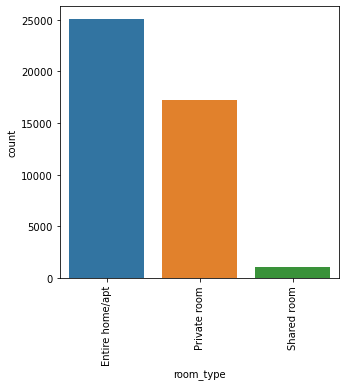

In [12]:
#Turn Scientific Notation back on so plots render correctly
pd.reset_option('display.float_format')

#Looking at the distribution of Room Type
plt.figure(figsize=(5,5))
sns.countplot(pdata['room_type'])
plt.xticks(rotation=90)
plt.show()

#### Property Type

The property type attribute had 35 unique values, and this level of detail made it difficult to visualize.  In order to understand the data at a higher level, we consolidated the data into two main property types and labeled the rest as "other", we may revisit this encoding as we experiment with feature selection for regression and classification.


In [13]:
#looking at the distribution of property type
pdata['property_type_original'] = pdata['property_type']


#value_list = ["Apartment","House","Condominium","Loft","Townhouse"]
value_list = ["Apartment","House"]
boolean_series = ~pdata.property_type.isin(value_list)
filtered_df = pdata[boolean_series]

filtered_df.head(100)

for i in list (filtered_df.index):
    pdata.loc[i,'property_type'] = "other"


#### Complete vs Consolidated Property Type

The following charts demonstrate the readability and ease of interpretation when the data is grouped into less categories.

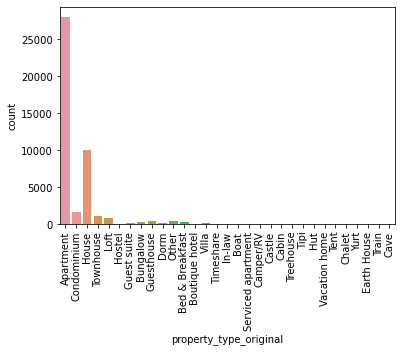

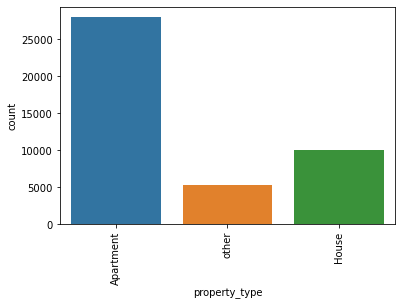

In [14]:
for i in ['property_type_original','property_type']:
    sns.countplot(pdata[i])
    plt.xticks(rotation=90)
    plt.show()

#### Volume of review score ratings and Price

##### Price
The violin plot helps us observe that a majority of the rentals for AirBnB cost less than $500

<AxesSubplot:xlabel='price'>

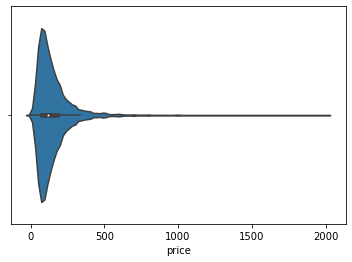

In [15]:
sns.violinplot(pdata['price'])

##### Score Ratings
It is interesting to see that a vast majority of the ratings are high and very few ratings are low.   


<AxesSubplot:xlabel='review_scores_rating'>

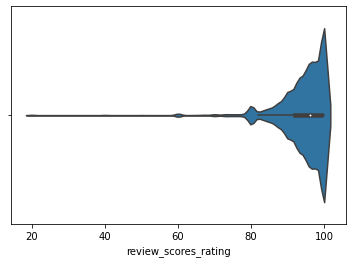

In [16]:
sns.violinplot(pdata['review_scores_rating'])

#### City data in dataset

It is important to note that there are significantly more rentals in the LA and NYC areas, this will be an important factor when using this data for predictive and classification purposes.

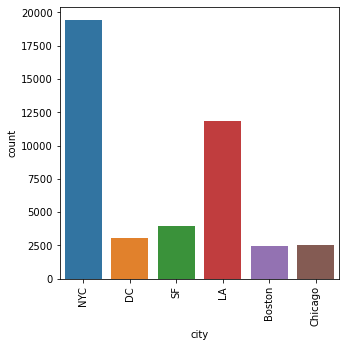

In [17]:
#Looking at the distribution of City
plt.figure(figsize=(5,5))
sns.countplot(pdata['city'])
plt.xticks(rotation=90)
plt.show()

In [18]:
#subset of data for reporting purposes

pdata_mod = pdata.drop(['cancellation_policy', 'description', 'first_review', 'host_has_profile_pic',
                'host_response_rate', 'host_since', 'last_review', 'cleaning_fee', 'latitude', 'longitude', 'id'], axis=1)

pdata_mod = pdata_mod.dropna()


## Explore Joint Attributes

#### Room Type vs Log Price

There is a clear delineation in log price by room type.  The shared rooms have lower prices than an entire home, where a private room is in the middle, with a lower price price than a whole house, altough some private rooms overlap with whole house prices.

#### Room Type vs Rating

There is less delineation in the customer reviews by room type.  As illustrated below. most customers that rate a place give favorable ratings regardless of room type and a few unfavorable ratings regardless of room type as well.  I think this is due to the fact that users are encouraged to leave a review of their stay by the property owners.


<Figure size 360x360 with 0 Axes>

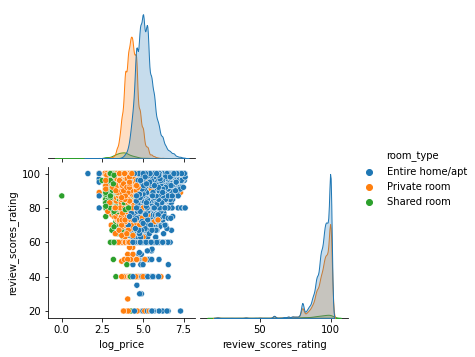

In [19]:
#https://seaborn.pydata.org/generated/seaborn.pairplot.html

plt.figure(figsize=(5,5))
sns.pairplot(pdata,vars=pdata_mod[['log_price','review_scores_rating']], hue = "room_type" ,diag_kind = 'kde', corner = True)
plt.show()

#### Beds vs Log Price by Room Type

There is a clear relationship in log price by number of beds and room type.  The shared rooms tend to have less beds and cost less than an entire home. Once again, the private room is in the middle, with a lower price price and number of beds than a whole house, altough some shared rooms also have multiple beds, this probably results in a more communal setting and a loss of privacy.

#### Room Type vs Number of Reviews

There a clear pattern in the number of reviews based on room type.  It appears that the number of reviews increase as the quality of the room shifts from private room to entire house.

#### Number of Bathrooms vs Room Type and Price

There is a clear linear relationship in the number of bathrooms based on room type and price.  The more a room costs, the more bathrooms it appears to have.  This is also affected by the type of property, since shared rooms also have several bathrooms but not the higher price.  There is also a strange anomaly where a private room has 8 bathrooms, I think this is a specific type of property that has several rooms and several bathrooms, like a shared space.  We will have to determine the leverage these outlying values have on our predictive power.

<Figure size 360x360 with 0 Axes>

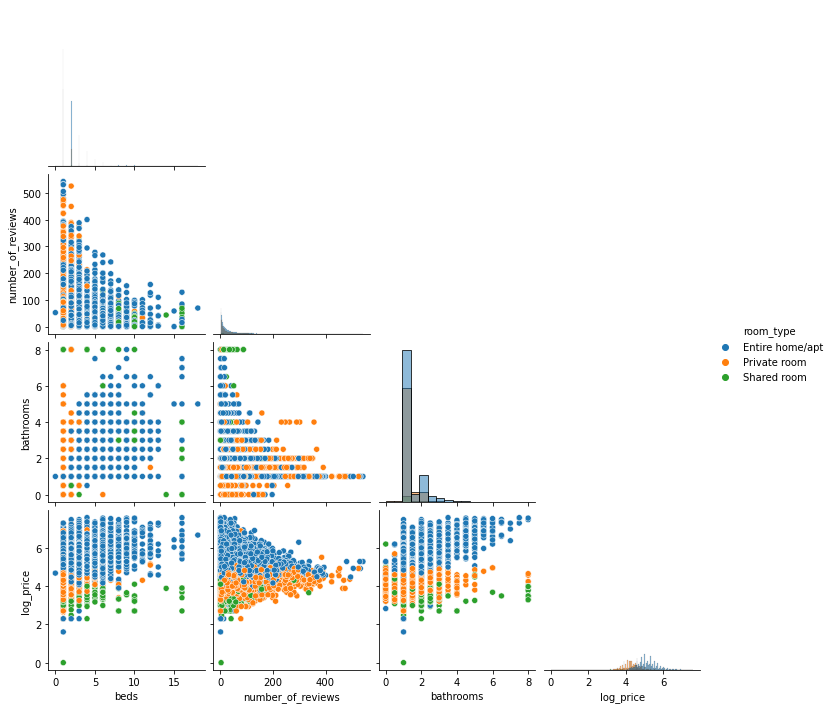

In [20]:
plt.figure(figsize=(5,5))
sns.pairplot(pdata,vars=pdata_mod[['beds','number_of_reviews','bathrooms','log_price']], hue = "room_type" ,diag_kind = 'hist', corner = True)
plt.show()

## Explore Attributes and Class

#### Price vs Review Scores

We first looked at the relationship between the log_price and the review_scores_rating. There doesn't appear to be a lot of evidence of linear correlation between the two variable, however, we can see that not many low scores are associated with high price.

The number_of _reviews appears to be normally distributed when compared with log_price. This means that most of the reviews are coming from those who are spending about average on the Airbnb rate. This is probably due to this being the most common price range for Airbnb listing and thus allows for a higher number of people to submit reviews.


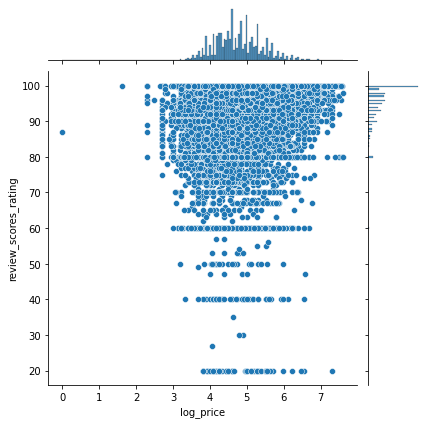

In [21]:
sns.jointplot(pdata['log_price'],pdata['review_scores_rating']);

#### Correlations

Next our heatmap shows us the correlation value between all of our variables. Specifically we are looking at the correlation between log_price and our other variabels. We can see a medium correlation (between 0.4 and 0.6) when log_price is compared with accommodates, bathrooms, bedrooms, and beds. These all make sense to be positively correlated with the price of an Airbnb. It is, however, interesting that the longitude and latitude of a property didn't play a major role in price as these would indicate where a property is located and location typically influences price.  There is also evidence that several attributes are highly correlated.  This makes sense as it would be logical that as number of rooms increase, so will the number of bathrooms and other property characteristics.  We will have to address the issue of multicollinearity as we begin modeling this data.

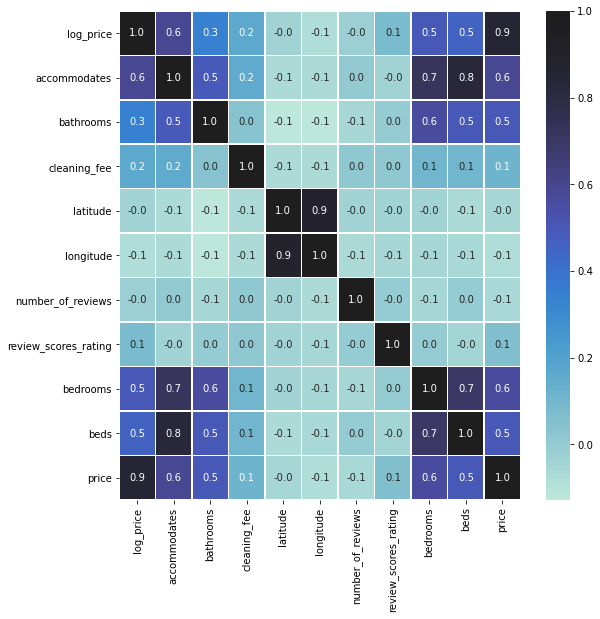

In [22]:
mydata = pdata.iloc[:, 1:27]
plt.figure(figsize=(9,9))
sns.heatmap(mydata.corr(), annot=True, linewidths=.5, fmt= '.1f', center = 1 )  # heatmap
plt.show()

#### Price vs City

Looking at the distribution of log_price across the 6 different cities contained in the data set we see that there is not a large discrepence in pricing in the various cities. Though the median is different in the 6 cities, the distributions mostly the same ranges and a different sample could potentially yeild more observations that are more equal.

<AxesSubplot:xlabel='city', ylabel='log_price'>

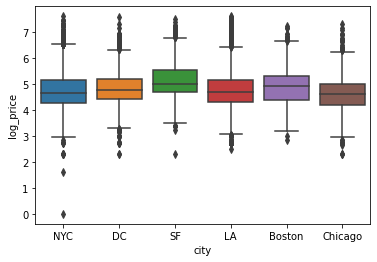

In [23]:
sns.boxplot(x='city', y='log_price', data=pdata)

#### Property Type

We then looked at how the property_type (broken into the three categories Apartment, House, and Other) interacted with cleaning_fee (T/F). We can see that all 3 property types share similar proportions between having a cleaning fee and not. This means that using cleaning fee to predict the property type won't yeild us the best results and we need to explore other interactions.

<AxesSubplot:xlabel='property_type', ylabel='count'>

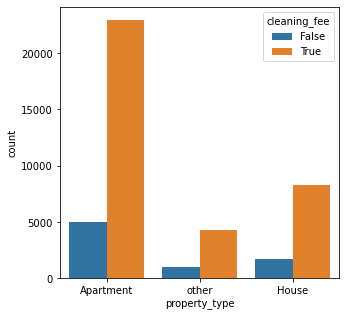

In [24]:
plt.figure(figsize=(5,5))
#sns.countplot(pdata['beds'], hue="property_type")
sns.countplot(x="property_type", hue="cleaning_fee", data=pdata)

#### Property Type by Number of Accommodations

Finally we looked at how the accommodates value and the property type would interact. Once agian we see similar distributions across the 3 types with the range being nearly identical on all 3. It may be more useful to predict using the unconsolidated data set, since it provides us a lot more information when identifying characteristics that distinguish the properties.

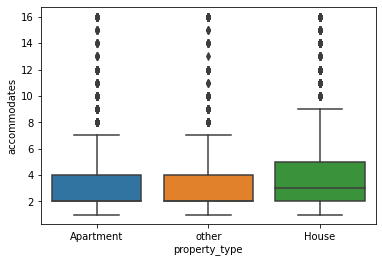

In [25]:
plot = sns.boxplot(x="property_type", y="accommodates", data=pdata)

0

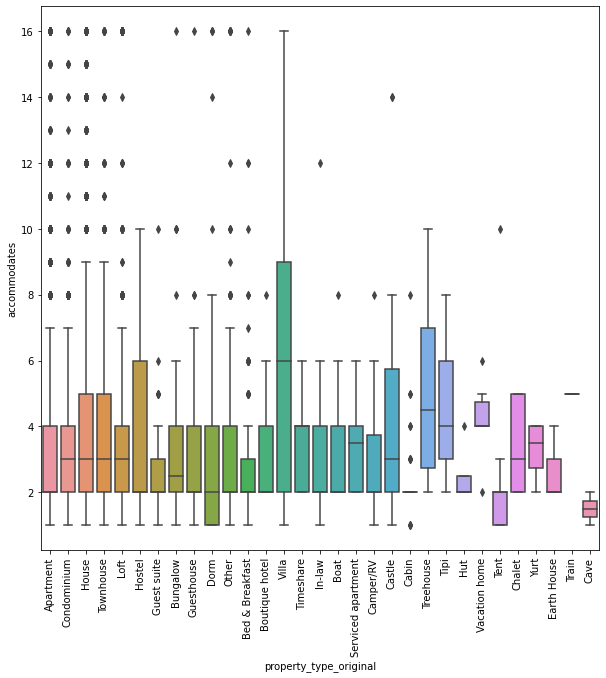

In [26]:
plt.figure(figsize=(10,10))
plot = sns.boxplot(x="property_type_original", y="accommodates", data=pdata)
plt.setp(plot.get_xticklabels(), rotation=90)
pdata.property_type_original.isna().sum()

## New Features

Creating a new variable based off of the region in the united states that the property is located could potentially yield interesting results. Though the individual cities may not drastically contribute to price, it is possible that grouped into a region we could see a little bit more definition between values.

Trying to find the age of the property would help as well in identifying both the price and the city that the property is located in. People are more likely to pay a higher price for a newer Airbnb than an older one except in the rare occasions that the property is an antique.

Finally finding the avg monthly temp of the properties could yeild great results in determining which city each property belongs to. We could potentially use this as well to predict pricing, however, it would not correlate as well as some of our other predictors do.

## Exceptional Work

#### Principal Component Analysis

Given the limited number of continuous variables, we were not surprised that it took three principal component eigen vectors to adequately explain > 80% of the variability in the data.

In [27]:
#https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [28]:
num_columns = ['log_price', 'bathrooms', 'latitude', 'longitude',
       'review_scores_rating', 'bedrooms', 'beds', 'price']
target = ['price']
target2 = ['property_type']

x = pdata.loc[:,num_columns].values
y = pdata.loc[:,target].values
z = pdata.loc[:,target2].values

After scaling the data we generate the Principal Component Analysis and print the eigen vectors.

In [29]:
#scale the data
x = StandardScaler().fit_transform(x)

#build PCA and print eigen vectors
pca = PCA(n_components=8)
pca_model = pca.fit(x)
print(pca_model.components_)

[[ 0.4393286   0.39750174 -0.11029644 -0.123473    0.02350388  0.45677344
   0.43311936  0.47411505]
 [ 0.09229434 -0.00170604  0.69569586  0.69138948 -0.06801843  0.10058732
   0.07917995  0.09193977]
 [-0.25003263  0.15585182 -0.05390374 -0.01875774 -0.90341159  0.12942666
   0.20674176 -0.18517697]
 [ 0.5432649  -0.42265525 -0.02421079 -0.06700851 -0.41636259 -0.29501198
  -0.30391029  0.41036344]
 [-0.03405549  0.76841956  0.03846743  0.04147628 -0.06157805 -0.29170114
  -0.53335737  0.17838185]
 [-0.05777833 -0.13750637  0.0171476  -0.05248281 -0.03605426  0.76863037
  -0.61838291 -0.01466966]
 [-0.63483204 -0.17108622 -0.1749652   0.16481203  0.01391598 -0.01665989
   0.04009434  0.71264522]
 [-0.1825082  -0.02037379  0.68407864 -0.68575162 -0.00503361 -0.03601584
   0.05059125  0.15548263]]


In [30]:
varianceExplained = pca_model.explained_variance_ratio_
cum_varianceExplained = np.cumsum(varianceExplained)

#### Variance Explained

As demonstrated in the percentage of variability explained in each eigen vector, the performance starts out quite low and past the third PCA the contributions get smaller, but they seem to contribute to the increase in % of variance explained, allowing the decision maker to determine the perfomance level they are comfortable with.

In [31]:
print(varianceExplained)

[0.40608527 0.23275016 0.12998993 0.09984081 0.06551623 0.03631555
 0.0158666  0.01363545]


#### Cumulative Variance

As observed in the individual contributions, the cumulative curve is quite sloped and not a sharp turn earlier in the PCA count as we would like to see.  This implies it takes multiple principle components to fully explain the variability in the data.

In [32]:
print(cum_varianceExplained)

[0.40608527 0.63883543 0.76882536 0.86866617 0.9341824  0.97049795
 0.98636455 1.        ]


### The Cumulative PCA Explanation chart

As seen in the individual contributions by  PCA, it takes 4 PCA eigen vectors to explain > 80% of the variability in our data

Text(0, 0.5, 'cumulative variance explained')

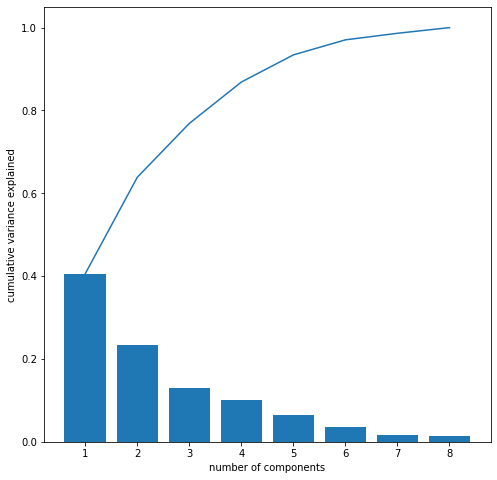

In [33]:
#class sample plot

plt.figure(figsize=(8,8))
plt.plot(range(1,varianceExplained.size+1),cum_varianceExplained)
plt.bar(range(1,cum_varianceExplained.size+1),varianceExplained)
plt.xlabel('number of components')
plt.ylabel('cumulative variance explained')

### Support Vector Machines - SVM

#### Support vector machines are a particularly powerful and flexible class of supervised algorithms for both classification and regression.

In [43]:
pdata = pd.get_dummies(pdata, drop_first=True)

In [ ]:
from sklearn impo
lasso_vars = lasso(alpha=0.10)
lasso_vars = fit(SVMx, SVMy)

In [45]:
SVMx = pdata.drop('log_price', axis=1)
SVMy = pdata['log_price']

In [46]:
#Split dataset into train and test
from sklearn.model_selection import train_test_split
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(SVMx, SVMy, test_size = 0.20)

In [48]:
#Import the SVM model
from sklearn.svm import SVC
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_svm, y_train_svm)

MemoryError: Unable to allocate 13.1 GiB for an array with shape (50909, 34656) and data type object

In [ ]:
#Predict the values
y_pred_svm = svclassifier.predict(X_test_svm)

In [ ]:
#Evaluate the SVM Model
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test_svm, y_pred_svm))
print(classification_report(y_test_svm, y_pred_svm))

In [ ]:
#MAPE
def mape(y_test_svm, y_pred_svm): 
    y_test_svm, y_pred_svm = np.array(y_test_svm), np.array(y_pred_svm)
    return np.mean(np.abs((y_test_svm - y_pred_svm) / y_test_svm)) * 100